In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import lasagne
import theano
import theano.tensor as T
import sys

Using gpu device 1: Quadro K4200 (CNMeM is enabled with initial size: 10.0% of memory, CuDNN 4007)


## The library

In this seminar we shall use [AgentNet](https://github.com/BladeCarrier/AgentNet/) library.
Agentnet, in essence, is an additional kit of lasagne layers that allow you to build custom recurrent layers.
Assuming you already have Bleeding Edge theano and lasagne, you can install it via
```
git clone https://github.com/yandexdataschool/AgentNet
cd AgentNet
python setup.py install
```
in whatever python, environment or container you exist. Alternatively, see docker install instructions in the [readme](https://github.com/yandexdataschool/AgentNet/blob/master/README.md).


Depending what python version do you use, in may be 
* `python3 setup.py install` \ `python2 setup.py install` if you are using a different python
* add sudo - `sudo python setup.py install` - if you have a superuser-installed python
* in case you have any problems - contact us or consider using a docker container (see above).


## A friendly warning

The problem we tackle here is of a relatively small scale, and so are the networks.
You can, of course, use GPU, but it is likely to consume more of your time when compiling (seriously, up to some 20-30 minutes), than what it saves during execution.

Consider switching to CPU and/or disabling optimization (theano.config.optimizer='None'


In [2]:
# Sorry, but my love for GPU's is too strong
sys.setrecursionlimit(100000)
floatX = theano.config.floatX
theano.config.optimizer = 'None'

In [3]:
%load_ext autoreload
%autoreload 2

# Stack-augmented RNN
![caption](https://usercontent1.hubstatic.com/6172838_f260.jpg)



## Today's menu

__The problem__ - train NN to generate sequences of `|`$ a^n b^m c^{n+m} $
 * n and m are positive integers picked randomly
 * What do we want exactly:
  * Sequence must have a correct form - `|`, some __a__'s, some __b__'s, than some __c__'s and `|` again
     * ||aaacbbcba would be a counterexample
  * A number of C letters must be as close as possible to the number of A and B letters together
     * Ideally, we want exact equality of them.
     
What do we try:
 * Vanilla RNN
 * Stack-augmented RNN
 
We shall train them as Language Models (like in Seminar10) - by reading the sequence and predicting the next symbol.
This time, however, we make predicitons on each time step and not just at the very end.

### First, let us generate the "correct" sequences

In [4]:
def generate_sequence(batch_size = 10,crop_length = 100 ):
    """
    Generates sequence from pattern [0  1*n 2*m 3*(n+m)]
    """
    sequences=[]
    for i in range(batch_size):
        seq = [0]
        
        while len(seq) < crop_length:
            m, n = np.random.randint(1, 16, 2)
            seq += [0] + [1]*n + [2]*m + [3]*(n+m)
        seq = seq[:crop_length]
        assert len(seq) == crop_length
        
        sequences.append(seq)
    return np.array(sequences,dtype='int32')

alphabet = np.array(list('|abc'))

### tests

In [5]:
%%time
map(''.join,map(alphabet.__getitem__,generate_sequence(25,100)))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.02 ms


['||aaabbbbbbccccccccc|aaaaaaaaaaaaaabbbbbbbbbbbbbbbccccccccccccccccccccccccccccc|aaabbbbbbbbbbbbccccc',
 '||aaaaaaaaaaaaabbbbbbbbbbbbbbbcccccccccccccccccccccccccccc|aaaaaaaaaabbbccccccccccccc|aaaaaaaaaaaaab',
 '||aaaaabbbbbbbcccccccccccc|aabccc|abbbbbbbbbbbcccccccccccc|aaaaaaaaaabbbbbccccccccccccccc|aaaaaaaabb',
 '||aaaaabbbbbbbbbbbbccccccccccccccccc|aaaaaaabbbbbbbbbbbbbcccccccccccccccccccc|aaaaaaaaaaaaaaabbbbccc',
 '||aaaaaaaabbbbbbbbbccccccccccccccccc|aaaaaaaaaaaaabbbbbbbbbbbbbcccccccccccccccccccccccccc|abbbcccc|a',
 '||aabccc|aaaaaaaabbbbbbbbbbbbbccccccccccccccccccccc|aaaaaaaaaaaaaabccccccccccccccc|aaaaaaaaaaaaaaabb',
 '||aaaaaaaaaaaaaaabbbcccccccccccccccccc|aaaaaaaaaaaaaabbbbbbbccccccccccccccccccccc|aaaaaaaaaaaaaabbbb',
 '||aaaaaabbbbbbbbbccccccccccccccc|aaaabbbbbbbbbbbccccccccccccccc|aaaaaaaaaaaaaabbbbbccccccccccccccccc',
 '||aaaaaaaaaaaabbbbbbbbbbbbbbbccccccccccccccccccccccccccc|aaaaaaaaaaaaaabbbbbbbbbbccccccccccccccccccc',
 '||aaaaaaaaaabbcccccccccccc|aaaaaaabcccccccc|aaaaaaaab

__Expected result__ of the tab above should be a list of strings like these


`
 ...
 '||aaaaaaaaabbbcccccccccccc|aaaabccccc|aaaaaaaaabbccccccccccc|aaaaaaaaabbbbccccccccccccc|aaaaaaaaaabb',
 '||aaaaaaaaaaaabbbbbbbbbbcccccccccccccccccccccc|aaaabbbbbbbbbbbbcccccccccccccccc|aaaabbbbbbbbcccccccc',
 '||aaaaaaabbbbbcccccccccccc|aaaaabbbbbbccccccccccc|aaaaaaaaaaaabbbbbccccccccccccccccc|abbbbbbbbbbbccc',
 '||aaaaaaaaaaaabbbbcccccccccccccccc|aaaaaaaabbbbbbbbcccccccccccccccc|aaaaaaaaaaaabbbbbbbbcccccccccccc',
 '||aaaaaaaaaaaaabcccccccccccccc|aaaaaaaaaaabbbbbbbbbbbbccccccccccccccccccccccc|aaaaaaaaaaaaaabbbbbbbb',
 '||abbbbccccc|aaaaabbbbbbbbbbbbccccccccccccccccc|aaaaaaaaaaaaabbbbbbbbbbbbccccccccccccccccccccccccc|a',
 '||aaaaaaaabbbbcccccccccccc|aaaabbbbbbbbbccccccccccccc|aaaaaaaaaaaabbbbbbbbbbbccccccccccccccccccccccc',
 '||aaaaaaaabbbbbbbbbbbbbccccccccccccccccccccc|aaaaaabbbbbbbbbbbbbbcccccccccccccccccccc|aaaaaaaaaaaaab',
 ...
`

In [7]:
from metrics import get_metrics

In [8]:
#formal tests
gen_sequences = generate_sequence(1000,500)
correctness_ratio, c_count_mae = get_metrics(gen_sequences,alphabet)

# checking that all sequences consist of repeated pattern | a+ b+ c+
assert correctness_ratio == 1.0
# All sequences must have the C letter count equal to the sum of A and B letters
assert c_count_mae == 0

#Finally, the sample must have the correct shape
assert len(gen_sequences) == 1000
assert len(gen_sequences[0]) == 500

# Constants and global variables

* Just some numbers that find their use farther in this notebook

In [9]:
# Generated sequence length
SEQ_LENGTH = 100

# size of a singe minibatch
BATCH_SIZE = 100

# total number of iterations
N_EPOCHS = 5000

# how often (one in that number of epochs) to print learning progress
REPORT_RATE = 50

In [10]:
#Input letters sequence of shape [batch,sequence_elem]
sequences_batch = T.matrix(dtype="int32",name="reference_sequences")

#it's size (theano-expression)
batch_size = sequences_batch.shape[0]


# Train some vanilla RNN

We are going to implement the graph below, defining a single step of RNN network.

* time ticks go from left to right
* inputs are at the bottom, outputs are at the top

![scheme](./rnn.png)

The key elements are 
* prev rnn state - input for previous RNN hidden state
* input letter - previous letter (as an input)
* next rnn state - new updated RNN hidden state
* generate_letter - a single letter chosen from RNN output probabilities
* everything else is just as simple

In [13]:
import lasagne
from lasagne.layers import DenseLayer, ElemwiseSumLayer, InputLayer, EmbeddingLayer, NonlinearityLayer
import agentnet
from agentnet.resolver import ProbablisticResolver
from agentnet.agent import Generator

In [14]:
#observation = input letter - previous letter input goes here
output_shape = (None,)

observation_layer = InputLayer(output_shape,name="obs_input")

# embedding
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer, input_size=n_tokens,
                               output_size=n_tokens, name = "input_embedding")

# RNN memory

#N hidden neurons
n_hid_1 = 70

#previous RNN state goes here
#~ prev rnn state
prev_rnn_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")

#complete RNN  using the scheme above

#<dense layer with None nonlinearity, None bias(b)  n_hid_1, outputs, takign embedding as input>
rnn_frominput = DenseLayer(obs_embedding, b=None, num_units=n_hid_1, name="rnn_from_input")
#<dense layer with None nonlinearity, None bias(b)  n_hid_1, outputs, takign prev RNN state as input>
rnn_fromhidden = DenseLayer(prev_rnn_layer, b=None, num_units=n_hid_1, name="rnn_from_hidden")

#<elementwise sum of these(ElemwiseSumLayer)>
rnn_sum = ElemwiseSumLayer([rnn_frominput, rnn_fromhidden])

#<nonlinearity (any reasonable one, tanh for example)>
rnn = NonlinearityLayer(rnn_sum, nonlinearity=lasagne.nonlinearities.tanh)

# This dictionary contains pairs {new state layer: prev state for this layer}

from collections import OrderedDict
memory_dict = OrderedDict([(rnn,prev_rnn_layer),])

#letter probabilities
probability_layer = DenseLayer(rnn, num_units = n_tokens,
                               nonlinearity=lasagne.nonlinearities.softmax, name="policy_original")

#resolver - picks a letter given probabilities

resolver = ProbablisticResolver(probability_layer, assume_normalized=True, name="resolver")

#check that input/output shape match (generated letters)
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)

#Creating a recurrent generator that
# - has 1 input - observation layer
# - has a memory, defined in memory dict ( single RNN )
# - generates letters given probabilities from probability layer
# - picks letters at resolver layer - proportionally to probabilities

agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )


/usr/local/lib/python2.7/dist-packages/agentnet/deprecated/generator.py:38: UserWarning: Generator class is deprecated and will be removed in 0.0.9.
Consider using agentnet.agent.Recurrence with all Generator features and more capabilities.
  warn("Generator class is deprecated and will be removed in 0.0.9.\n"\
/usr/local/lib/python2.7/dist-packages/agentnet/deprecated/base.py:35: UserWarning: BaseAgent class is deprecated and will be removed in 0.0.9.
Consider using agentnet.agent.Recurrence with all BaseAgent features and more capabilities.
  warn("BaseAgent class is deprecated and will be removed in 0.0.9.\n"\


# Now let's unroll the recurrence

* In this case, we make agent observe the reference letters from the input variable above
  * helps to speed up the training.
* the output essentially mimics lasagne.layers.RecurrentLayer, GRU or LSTM

In [15]:
sessions = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)

# RNN hidden sequence(s) - wouldbe-generated letters  - probabilities
agent_states, action_seq, probas_seq = sessions

# taking a particular RNN (the only one in our case)
rnn_seq = agent_states[rnn]

# and yes - we only really needed the probas_seq out of all these lines

### The rest is like what you usually do with lasagne

### weights

In [17]:
#get weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)

In [18]:
total_weights = int(T.sum([T.prod(w.shape) for w in weights]).eval())
print "Total weights:", total_weights

#if you are tinkering with network size - remove the next line
assert  5200 < total_weights <= 5700

Total weights: 5480


# Loss function

* Use simple crossentropy, just like in the seminar 10
* Only this time we make predictions for next letters at all time steps

In [19]:

# take all predictions but for last(since we don't know reference "next" letter for it)
predicted_probas = probas_seq[:,:-1]

# minimal probability threshld to avoid -Inf in crossentropy logarithm
predicted_probas = T.maximum(predicted_probas,1e-10)

# the reference answers - for 0-th "next letters" prediction - 1-st input letter, for 1-st - the 2nd input and so on
# the 0-th reference can be thrown away
references = sequences_batch[:,1:]

# the regular crossentropy
model_loss = lasagne.objectives.categorical_crossentropy(predicted_probas.reshape([-1,n_tokens]),references.ravel()).mean()

In [20]:
#regularizer for spice
from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-5
loss = model_loss + reg_l2

In [21]:
#<your favorite optimizer>
updates = lasagne.updates.adam(loss, weights)

# Compile the entire thing.
* First compilation with SEQ_LENGTH above 25 may take several mugs of coffee to complete
* If you are using GPU - it takes these same mugs plus a cake.
* Btw cake consists layers just like your RNN does. This was supposed to be philosophical.

![canvas](http://www.rabstol.net/uploads/gallery/main/322/rabstol_net_cakes_30.jpg)

* p.s Cake is a lie!

### Also, Ogres

![canvas](shrek.jpg)

In [22]:
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])

# Generating new symbols

In [23]:
# generated sequences batch size goes here
gen_batch_size = T.scalar('generated batch size','int32')

# just like the previous time, but we omit the reference sequence, allowing generator
# to use it's own outputs as next inputs
_, generated_action_seq, _ = agent.get_sessions(session_length=SEQ_LENGTH, batch_size=gen_batch_size,)

In [24]:
#finishing that coffee
#how about a pack of columbian dark roasted as the best project award? Just sayin
get_sequences = theano.function([gen_batch_size],generated_action_seq)

In [25]:
#Right now our network knows nothing (like Jon Snow, but for <spoiler>)
map(alphabet.__getitem__,get_sequences(3))

[array(['b', 'c', 'c', 'c', '|', '|', 'b', 'a', 'b', '|', 'a', 'c', 'a',
        '|', 'b', '|', 'b', 'a', '|', 'c', '|', '|', '|', '|', 'c', 'c',
        '|', 'c', 'b', 'c', 'b', '|', '|', 'c', 'c', 'a', 'c', 'a', '|',
        '|', 'a', 'b', '|', 'c', 'c', 'c', 'a', 'b', 'c', 'b', 'a', 'c',
        'b', '|', 'b', 'b', 'b', 'c', '|', 'c', 'c', 'c', '|', '|', 'b',
        '|', 'b', 'c', 'b', 'c', 'b', 'a', 'b', 'c', 'b', 'a', 'c', 'b',
        'b', '|', 'c', 'c', 'a', '|', 'c', '|', 'a', 'a', 'a', '|', 'c',
        'b', 'a', 'b', 'a', 'c', 'a', 'a', 'b', 'c'], 
       dtype='|S1'),
 array(['a', 'c', 'a', 'b', 'a', 'c', 'a', '|', 'b', '|', 'c', '|', 'c',
        'c', 'b', '|', 'b', 'b', 'c', 'a', 'a', '|', 'b', 'c', 'b', 'b',
        'a', 'b', 'c', 'b', 'b', 'a', '|', 'b', 'c', 'a', '|', 'c', '|',
        'b', 'c', 'b', '|', 'a', 'a', 'a', 'b', 'c', 'b', 'b', '|', 'b',
        'b', 'c', 'a', 'c', 'a', 'a', 'a', 'a', 'b', 'a', 'c', '|', 'a',
        'b', 'a', 'a', '|', 'c', 'a', 'c', '|', 

# Training loop

* Just as usual - training for N iterations and computing metrics

* We shall monitor 3 metrics - 
 * llh - simply loglikelihood - expected to decrease over time
 * Correctness rate - what is the probability of generating the correct sequence format, matching "^|a+b+c+"
   * expected to grow
 * C error rate
   * among the correct sequences, what is the mean absolute error (MAE) between the amount of "C"s we generated and what we should have, taking As and Bs into account.


In [26]:
from collections import defaultdict
metrics = defaultdict(dict)

In [27]:
for i in range(N_EPOCHS):
    
    #generate the sequences
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    #feed the beast
    train_fun(new_batch)
    
    #Once in a while, display metrics
    if not i%REPORT_RATE:
        
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))        
        
        metrics['crossentropy'][i]=float(loss_components[1])
        examples = get_sequences(1000)
        
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        
        print "Correctness rate: %.5f"%(correctness_ratio)
        print "C count MAE for correct ones: %.5f"%(c_count_mae)
        
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))

iter:0	full:1.38627	llh:1.38542	reg:0.00086
Correctness rate: 0.03647
C count MAE for correct ones: 2.60624
b c | c | a | c b c a c c a c a b a c c c b | | | | a c | b a b | a b b b c b | a | | a c c c c a | a b c a | b a c | a | a b c | b c c c | c | | c c b a a b a b b | b | c a c a c | | c a | c a c | |
| b | | a a c c a | a | a b | | c b c c | b c | a c | | | a c | c a | | c a b a b a c a | a | a c | b | c c b | b b c c b | b c b c | c | | a c a | b a | c | b a c b c b a a | | | a c c c b b | c b |
b | a | b b a b | c | a | | | c b b b | c a b b | | a b a b c a c b a c c b c b c c a c b a b | | a | b b a a b b b | a c | a | | a c | b a b c a a a a a a c c b b | a a c | b b a | | a a b | b a b b
iter:50	full:1.05792	llh:1.05706	reg:0.00086
Correctness rate: 0.05453
C count MAE for correct ones: 4.25258
c | b b b | a c b a b b c b b b c b c | a c c a c c a c b b b b c a a c c b a c a c b b a c c c c b b a a a c c c b b c c b c c a c b c c c b c c b b c c c c c c c c a c a c b c c b a

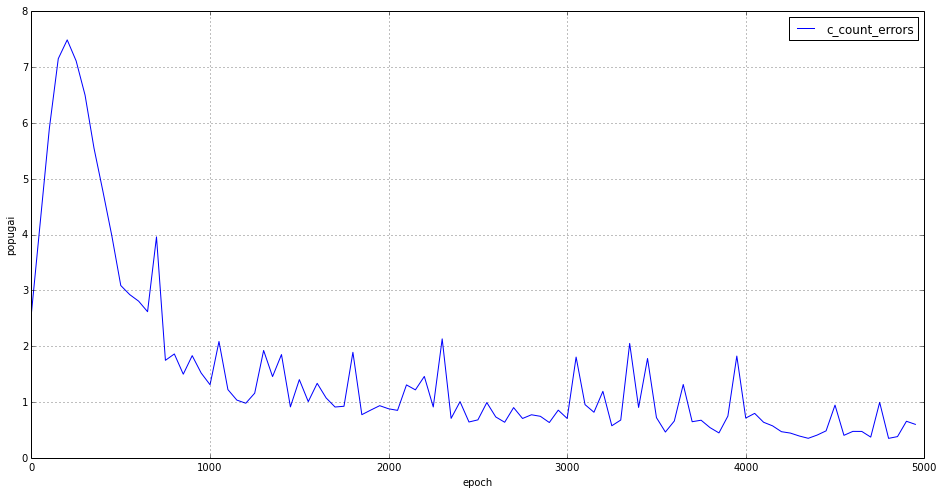

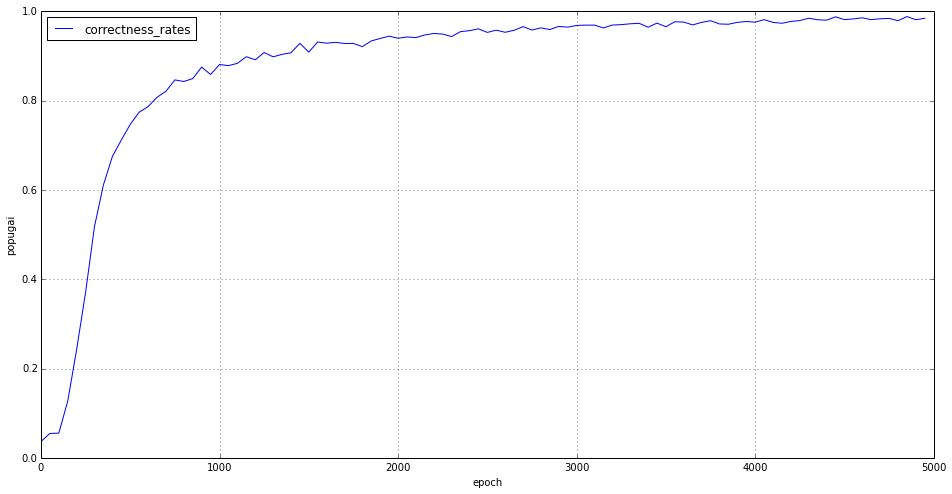

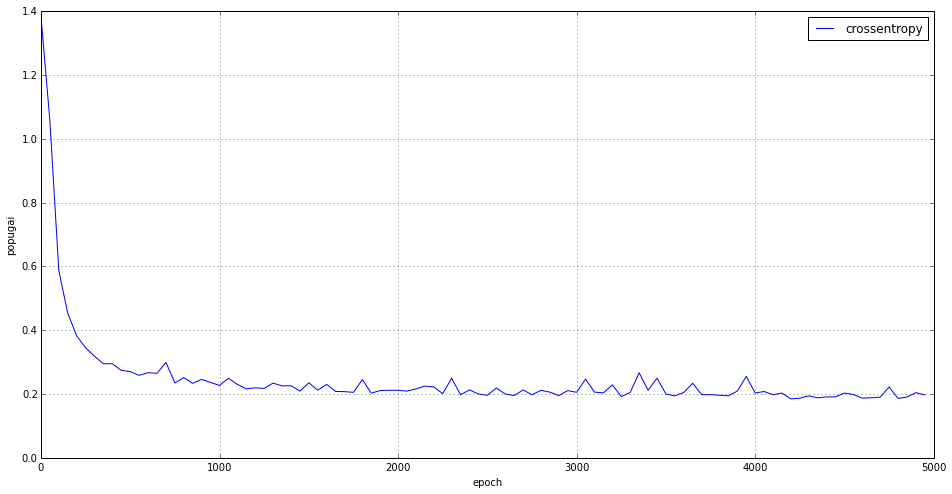

In [28]:
for metric in metrics:
    plt.figure(figsize=[16,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label=metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()

## tests

In [29]:
get_5_last = lambda metric_name: map(lambda v: v[1],sorted(metrics[metric_name].items(),key=lambda v:v[0])[-5:])

# assert metrics are below thresholds

assert min(get_5_last("crossentropy")) <= 0.3
assert min(get_5_last("c_count_errors")) <= 3
assert min(get_5_last("correctness_rates")) >= 0.8

In [30]:
#remember the logs for future plots
rnn_metrics = metrics

# Stack RNN

Here goes the Stack-augmented RNN.

The original paper - http://arxiv.org/abs/1503.01007
(with pictures)

Let's allocate a stack for out RNN to store data in. The stack has  control operations

* push - pushing stack one element deeper, adding input element
* pop - move everything one element shallower, removing the top
* no-op - preserving the previous state

The operations are generalized to allow performing them to an extent from 0 to 1
* 0 - operation not applied
* 1 - operation applied as in the regular stack
* Anything inbetween - operation is partially applied 
* Constraints
  * `0 <= push, pop, no-op <= 1`
  * `push + pop + no-op = 1`

The stack update rule looks thus:

```Stack(depth i, t+1) = push * Stack(depth i+1, t) + pop * Stack(depth i-1, t) + no-op * Stack(depth i, t)```


* The "Input" element for push is yet another dense layer dependent on hidden RNN state
* When doing pop, the stack is padded with zeros from the bottom (deepest, farthest from input)
* The first (depth 0) stack value is given as an input to the recurrent layer



How do we implement it?
 * Create a layer implementing one step of stack memory
 * Plug it into network
 * ???
 * PROFIT!!!



# Stack memory

In [31]:
from lasagne.layers.base import MergeLayer

class StackAugmentationLayer(MergeLayer):
    def __init__(self,
                 observation_input,
                 prev_state_input,
                 controls_layer,
                 **kwargs):

        #default name
        if "name" not in kwargs:
            kwargs["name"] = "YetAnother"+self.__class__.__name__
        super(StackAugmentationLayer, self).__init__([observation_input,prev_state_input,controls_layer], **kwargs)

    def get_output_for(self, inputs, **kwargs):
        """
            Inputs
             - input element of shape [None, stack width]
             - previous stack state of shape [None,stack depth, stack width]
             - vector controls of shape [None, 3] - push, pop and no-op accordingly

            This function should return the updated stack state.
        """

        #unpack inputs
        input_val,prev_stack,controls = inputs
        assert input_val.ndim==2

        #some shape transformations to make your math smoother
        controls = controls.reshape([-1,3,1,1])    
        input_val = input_val[:,None,:]
        zeros_at_the_top = T.zeros_like(prev_stack[:,0,None,:])

        # stack control operations
        a_push,a_pop,a_no_op = controls[:,0],controls[:,1],controls[:,2]

        # Intermediate stage - prepare stack versions, shifted one row down (push) and up(pop)
        # Adding the edge elements (input and last element) is easier via T.concatenate(axis=1) or T.horizontal_stack

        #<stack shifted 1 row up, first element thrown away, stack end padded with zeros_at_the_top>
        stack_popped = T.concatenate([prev_stack[:,1:,:], zeros_at_the_top], axis=1)
        #<stack shifted 1 row down, deepest element forgotten, new first element is input_val>        
        stack_pushed = T.concatenate([input_val, prev_stack[:,:-1,:]], axis=1)
        #<a formula for new stack state using 3 controls>
        #Stack(depth i, t+1) = push * Stack(depth i+1, t) + pop * Stack(depth i-1, t) + no-op * Stack(depth i, t)

        new_stack = a_push * stack_pushed + a_pop * stack_popped + a_no_op * prev_stack
        return new_stack
    
    def get_output_shape_for(self, input_shapes):
        """
        A lasagne layer method that returns output shape - already implemented for you.
        """
        observation_shape,last_memory_state_shape,controls_shape = input_shapes
        
        return last_memory_state_shape

# StackRNN structur
![canvas](stack-rnn.png)


* Brace yourselves! It will turn out simpler than it seems
* Every new componemt has a __bold black__ frame, the rest is vanilla RNN
* Prev stack / Next stack - previous and new stack states
* StackAugmentation - the stack autmentation layer you have just implemented
* Stack Input и Controls - simple Dense layers
* First - An operation of taking the outermost stack element (SliceLayer)

To save your time, the vanilla RNN is already implemented here so that you could focus on stack augmentation.
* If you prefer your own implementation, just copy-paste it where appropriate

In [32]:
#observation - previous generated letter goes here
output_shape = (None,)
observation_layer = InputLayer(output_shape,name="obs_input")

# Token embedding
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer,
                                              input_size=n_tokens,
                                              output_size=n_tokens,
                                              name = "input_embedding")

#RNN hidden state size - a bit smaller to compensate for stack controls
n_hid_1 = 64

#previous RNN state goes here
prev_rnn_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")

# previous stack state is defined here
stack_width = 3
stack_depth = 50

prev_stack_layer = InputLayer((None,stack_depth,stack_width))

# Controls
# <stack controls layer - takes RNN hidden state and outputs 3 neurons whose output sum to 1 (softmax or norm)>
stack_controls_layer = DenseLayer(prev_rnn_layer, num_units=3, name='stack controls', b=None,
                                  nonlinearity=lasagne.nonlinearities.softmax)

# Stack input
# <a dense layer with any(say, tanh) nonlinearity, used to represent stack inputs for pushing>
stack_input_layer = DenseLayer(prev_rnn_layer, num_units=stack_width, name='rnn stack to hidden', b=None,
                               nonlinearity=lasagne.nonlinearities.tanh)
    
#Get the new stack state using your update function
next_stack = StackAugmentationLayer(stack_input_layer,
                                    prev_stack_layer,
                                    stack_controls_layer)

#Take stack top (First) to feed it into RNN
stack_top = lasagne.layers.SliceLayer(next_stack,0,1)

# RNN memory

#RNN from input
rnn_frominput = DenseLayer(obs_embedding,
                           num_units=n_hid_1,
                           name= "rnn input to hidden",
                           b = None,
                           nonlinearity = None)
#RNN from hidden
rnn_fromhidden = DenseLayer(prev_rnn_layer,
                            num_units=n_hid_1,
                            name= "rnn hidden to hidden",
                            nonlinearity = None,)
                            
#RNN from stack
#<RNN updates based on stack_top>
rnn_fromstack = DenseLayer(stack_top, 
                            num_units=n_hid_1,
                            name= "rnn stack to hidden",
                            nonlinearity = None)

rnn_sum = ElemwiseSumLayer([
        rnn_frominput,
        rnn_fromhidden,
        rnn_fromstack     
    ],
    name = "rnn_sum")
# this thing above is essencially a 3-input RNN

rnn = NonlinearityLayer(rnn_sum,lasagne.nonlinearities.tanh,
                        name = "rnn nonlinearity")

# This dictionary maps {hidden state outputs : hidden_state_inputs}
# with stack now among them.
from collections import OrderedDict
memory_dict = OrderedDict([
            (rnn,prev_rnn_layer),
            (next_stack, prev_stack_layer)
    ])
#next letter probabilities

probability_layer = lasagne.layers.DenseLayer(rnn,
                                         num_units = n_tokens,
                                         nonlinearity=  lasagne.nonlinearities.softmax,
                                         name="policy_original")

#resolver - picks the next letter as before

resolver = ProbablisticResolver(probability_layer,
                                assume_normalized=True,
                                name="resolver")

#input/output shape check
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)

#Creating a generator, again, just liek before

agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )

# FUN!

In [33]:
#get weights - make sure all stack-related parameters are there
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[input_embedding.W,
 rnn input to hidden.W,
 rnn hidden to hidden.W,
 rnn hidden to hidden.b,
 rnn stack to hidden.W,
 stack controls.W,
 rnn stack to hidden.W,
 rnn stack to hidden.b,
 policy_original.W,
 policy_original.b]

In [34]:
total_weights = int(T.sum([T.prod(w.shape) for w in weights]).eval())
print "Total weights:", total_weights

#if you are experimenting with network size, remove the next line
assert 5000 < total_weights <= 5500

Total weights: 5332


# Copy-paste time

Here comes the same code used to train RNN 
- but now it's packed a bit more tightly
- __everything you need is to copy-paste optimizer line there__

In [41]:
probas_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)[-1]

model_loss = lasagne.objectives.categorical_crossentropy(
    T.maximum(probas_seq[:,:-1],1e-10).reshape([-1,n_tokens]),
    sequences_batch[:,1:].ravel()
).mean()

loss = model_loss + regularize_network_params(resolver,l2)*(10**-5)

In [42]:
updates = lasagne.updates.adam(loss, weights)

In [43]:
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])

In [44]:
gen_batch_size = T.scalar('generated batch size','int32')
generated_action_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             batch_size=gen_batch_size,)[-2]
get_sequences = theano.function([gen_batch_size],generated_action_seq)

# Training loop - Stack-Augmented RNN

* Just as usual - training for N iterations and computing metrics

* We shall monitor 3 metrics - 
 * llh - simply loglikelihood - expected to decrease over time
 * Correctness rate - what is the probability of generating the correct sequence format, matching "^|a+b+c+"
   * expected to grow
 * C error rate
   * among the correct sequences, what is the mean absolute error (MAE) between the amount of "C"s we generated and what we should have, taking As and Bs into account.


In [45]:
metrics = defaultdict(dict)

In [46]:
for i in range(N_EPOCHS):
    
    #generate sequences
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    #feed the beast
    train_fun(new_batch)
    
    #Once in a while, display metrics
    if not i % REPORT_RATE:
        
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))        
        
        metrics['crossentropy'][i]=float(loss_components[1])
        

        examples = get_sequences(1000)
        
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        

        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        
        print "Correctness rate: %.5f"%(correctness_ratio)
        print "C mean absolut error: %.5f"%(c_count_mae)
        
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))

iter:0	full:1.44042	llh:1.43946	reg:0.00247
Correctness rate: 0.02601
C mean absolut error: 2.16637
c b | c a a a c | c c | a a c | b c | | | a | b | b b a | | c c | b | a b a | c c a a c b a | c b c c c c b b | c a b | b c c b | a c a | | a | | c | c a | c c c a a b | c | c b a | c | | c | | c a |
| a b b c b a c c | c | b b b b | a b c a b b b | a | c | | c b | | | c c c c | | b a | c c a | | c | a a b c c | a a c c | | | a c | a c b | c a c | c a b a c b b a | b c b c | | b c b a c | a c | |
b c c b c a b c a a c b a b b | | | b | c b b a | | | a a | c | a c c | c c a b b a b | | b b | a | a c | | | b b | b b c | a | | c | | c | | c a b c c c a c | | | c a a | c b b c a c | | | c | a | a
iter:50	full:0.92036	llh:0.91938	reg:0.00247
Correctness rate: 0.05214
C mean absolut error: 5.04861
b | b a c a c | a a a a a b b a b a a c b a b b c a c a b c c c | c b c | a c c c a a c a a a | c a a c a c a | a c a c a b c c c c c a b b c c c a a c b c c a c a c c b c b a a c c c c c a a a a c c

# Тестики

In [47]:
get_5_last = lambda metric_name: map(lambda v: v[1],sorted(metrics[metric_name].items(),key=lambda v:v[0])[-5:])

#quality thresholds

assert min(get_5_last("crossentropy")) <= 0.25
assert min(get_5_last("c_count_errors")) <= 1
assert min(get_5_last("correctness_rates")) >= 0.9

# Learning curves

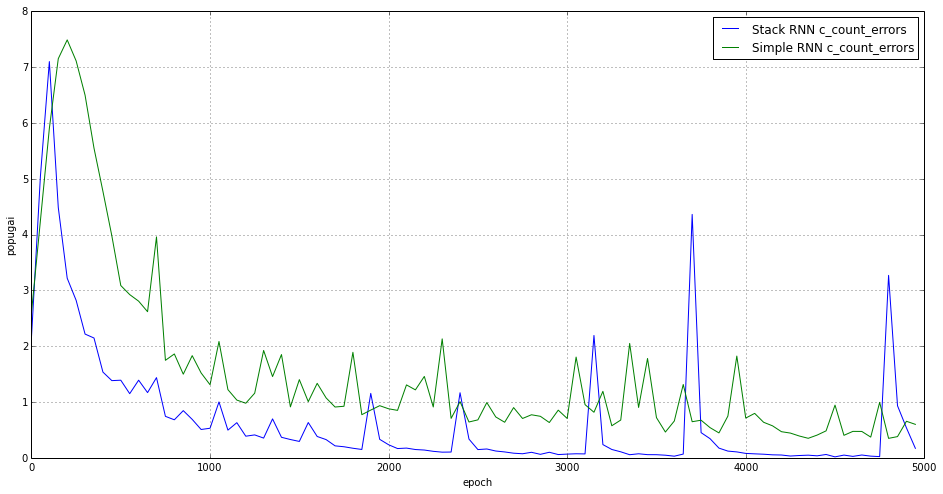

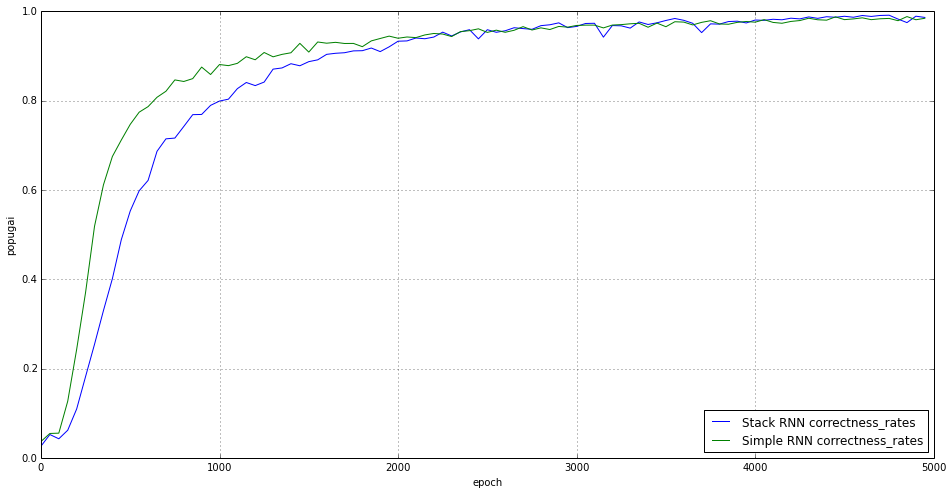

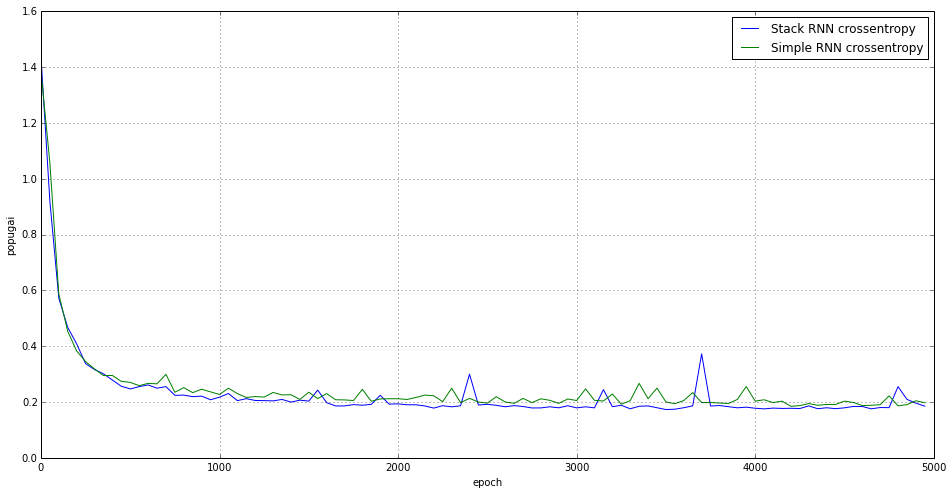

In [49]:
for metric in metrics:
    plt.figure(figsize=[16,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label='Stack RNN '+metric)
    plt.plot(*zip(*sorted(rnn_metrics[metric].items(),key=lambda (k,v):k)),label='Simple RNN '+metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()
    plt.show()

# Quest for CPU-time

* Will the results change (and how) if you divide neuron counts by 2 for both cases?
* What if we change stack width and it's depth? What minamal depth achieves any reasonable effect?
* What if we use several stacks?
* Finally, what happens if we generate longer/shorter sequences? (make sure they are still within sequence length)

**_Let’s find out!_**

**_Here are copy-pastes of relevant cells from the above._**

**_Dividing neuron counts by 2: vanilla RNN_**

In [54]:
from collections import OrderedDict

**_Dividing neuron counts by 2: stack-augmented_**

iter:0	full:1.29513	llh:1.28905	reg:0.00247
Correctness rate: 0.04362
C mean absolut error: 2.91707
b c c c | | c a b | a c a | b | b a | c | | a a c c a c c c b | | c c b c a | a a c | c c c a b c b b c b | b b b c | c c c | | b a b c b c b b c c c b c c b a c c b | c | a a b | c b b c a c a b c c
a c a b a c a | b a c a c c b | b b c a a | b c b b a b c c b a a b c a | c | b c b | b b b b c b b a b b c a c b a a b b b c | a c b a | c a c a a a c a c a a c b c a c | c a a c b b c | b c c | b c
b | b c c | a b a c | c b a a a b | a a b b b | a c a | c a c b c a c c b b a a c b c | c b a c a | | c c a b b b c c a a a b b | c | b c c b | b a c c b c | b b | c | c c | b a | b c c a b c b c b b
iter:500	full:0.19587	llh:0.18520	reg:0.00247
Correctness rate: 0.93856
C mean absolut error: 0.25676
a a a a b b b b b b b b b b b c c c c c c c c c c c c c c | a a a a a a a a a a a a b b c c c c c c c c c c c c c c | | a a a a b b b c c c c c c c c | | a a a a a a a a a a a a b b b b b b b b b b 

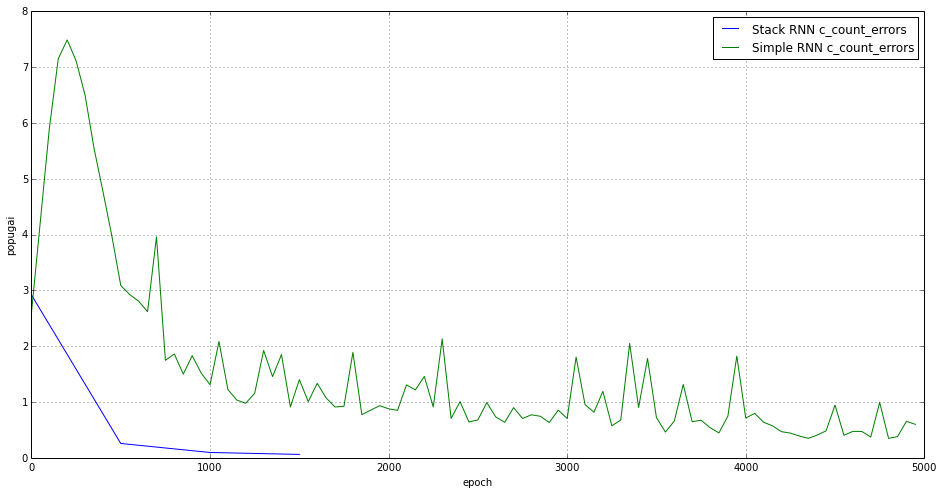

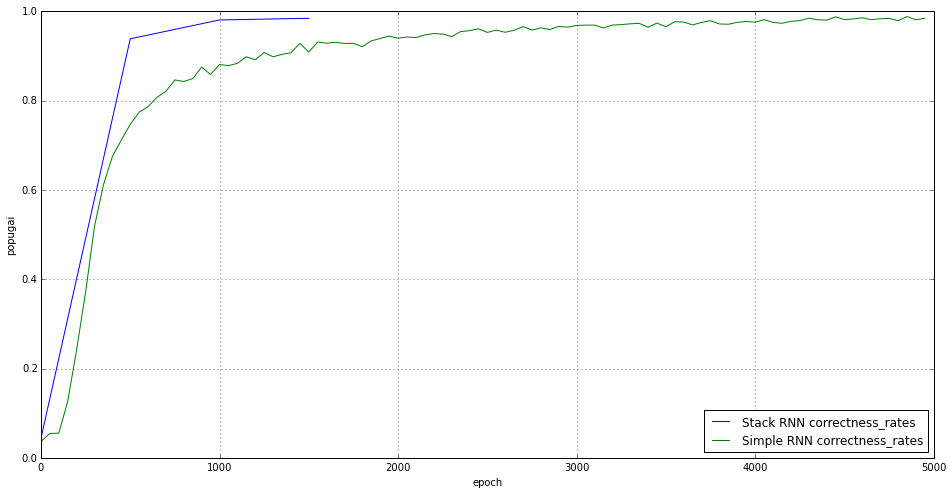

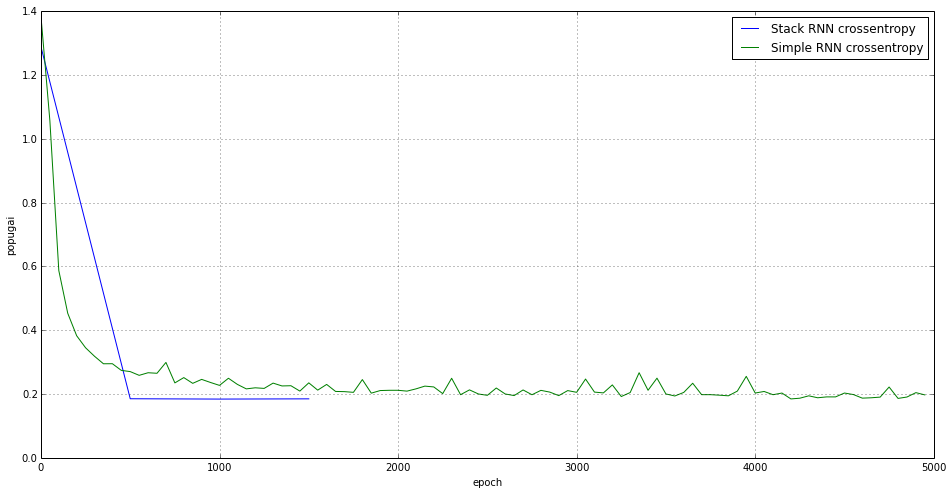

In [51]:
N_EPOCHS = 2000 
REPORT_RATE = 500

output_shape = (None,)
observation_layer = InputLayer(output_shape,name="obs_input")
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer,
                                              input_size=n_tokens,
                                              output_size=n_tokens,
                                              name = "input_embedding")
n_hid_1 = 32
prev_rnn_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")
stack_width = 3
stack_depth = 50
prev_stack_layer = InputLayer((None,stack_depth,stack_width))
stack_controls_layer = DenseLayer(prev_rnn_layer, num_units=3, name='stack controls', b=None,
                                  nonlinearity=lasagne.nonlinearities.softmax)
stack_input_layer = DenseLayer(prev_rnn_layer, num_units=stack_width, name='rnn stack to hidden', b=None,
                               nonlinearity=lasagne.nonlinearities.tanh)
next_stack = StackAugmentationLayer(stack_input_layer,
                                    prev_stack_layer,
                                    stack_controls_layer)
stack_top = lasagne.layers.SliceLayer(next_stack,0,1)
rnn_frominput = DenseLayer(obs_embedding,
                           num_units=n_hid_1,
                           name= "rnn input to hidden",
                           b = None,
                           nonlinearity = None)
rnn_fromhidden = DenseLayer(prev_rnn_layer,
                            num_units=n_hid_1,
                            name= "rnn hidden to hidden",
                            nonlinearity = None,)
rnn_fromstack = DenseLayer(stack_top,
                            num_units=n_hid_1,
                            name= "rnn stack to hidden",
                            nonlinearity = None)
rnn_sum = ElemwiseSumLayer([
        rnn_frominput,
        rnn_fromhidden,
        rnn_fromstack
    ],
    name = "rnn_sum")
rnn = NonlinearityLayer(rnn_sum,lasagne.nonlinearities.tanh,
                        name = "rnn nonlinearity")

memory_dict = OrderedDict([
            (rnn,prev_rnn_layer),
            (next_stack, prev_stack_layer)
    ])
probability_layer = lasagne.layers.DenseLayer(rnn,
                                         num_units = n_tokens,
                                         nonlinearity=  lasagne.nonlinearities.softmax,
                                         name="policy_original")
resolver = ProbablisticResolver(probability_layer,
                                assume_normalized=True,
                                name="resolver")
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)
agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )
weights = lasagne.layers.get_all_params(resolver,trainable=True)
probas_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)[-1]
model_loss = lasagne.objectives.categorical_crossentropy(
    T.maximum(probas_seq[:,:-1],1e-10).reshape([-1,n_tokens]),
    sequences_batch[:,1:].ravel()
).mean()
loss = model_loss + regularize_network_params(resolver,l2)*10**-4
updates = lasagne.updates.adadelta(loss, weights)
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])
gen_batch_size = T.scalar('generated batch size','int32')
generated_action_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             batch_size=gen_batch_size,)[-2]
get_sequences = theano.function([gen_batch_size],generated_action_seq)
metrics = defaultdict(dict)
for i in range(N_EPOCHS):
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    train_fun(new_batch)
    if i % REPORT_RATE==0:
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))
        metrics['crossentropy'][i]=float(loss_components[1])
        examples = get_sequences(1000)
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        print "Correctness rate: %.5f"%(correctness_ratio)
        print "C mean absolut error: %.5f"%(c_count_mae)
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))
for metric in metrics:
    plt.figure(figsize=[16,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label='Stack RNN '+metric)
    plt.plot(*zip(*sorted(rnn_metrics[metric].items(),key=lambda (k,v):k)),label='Simple RNN '+metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()
    plt.show()

**_Changing stack dimensions: width = 2_**

iter:0	full:1.39867	llh:1.38959	reg:0.00247
Correctness rate: 0.03409
C mean absolut error: 2.50698
b c c c | | c a b | a c a | b | b a | c | | | | c c | c b c b | | c c a c a | | a b | c c c a b c b a c b | b b b c | c c c | | b | b c b c b a b c b a c b b | c c a | c | | a a | b b a b | c | a b b
a c a b a c a | b | c | c c b | b b c a a | b c b b a b c b b a | b c a | c | b c b | a a a b c b b | b b c a c a a a a b a c | a b a a | c | c | | | c a c a | c a c | c | b | | c b b c | b c c | a c
b | b c c | a b a c | c b a a a b | a | b b b | a c | | c | c a b a c b a b | | c a b | c b | b | | | c c a b b a c c | a a b b | c | a c c b | b | c b b c | a b | c | c c | b a | b c c a b c a c a b
iter:500	full:1.39833	llh:1.38925	reg:0.00247
Correctness rate: 0.03458
C mean absolut error: 2.60031
c | a c c | a | | | b a c | | c a | c b b a b | | c c b b b c | | a | | b | | | b a c b c b a c | | a b b | b b a c b | a b c b c | | c a b | | | | a b | a c | b c a b a a a a | c c a b c b a | a a 

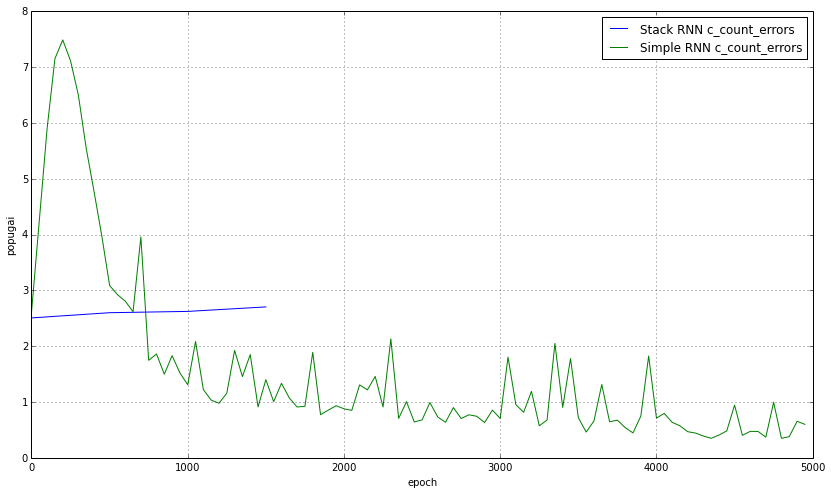

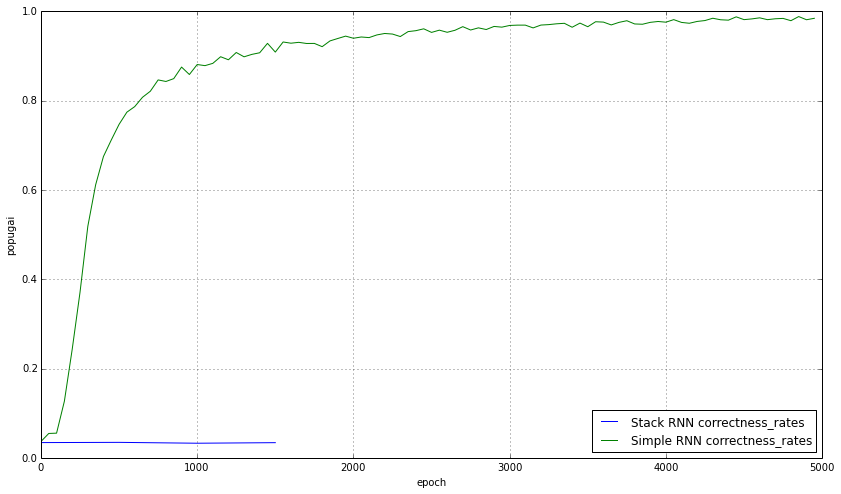

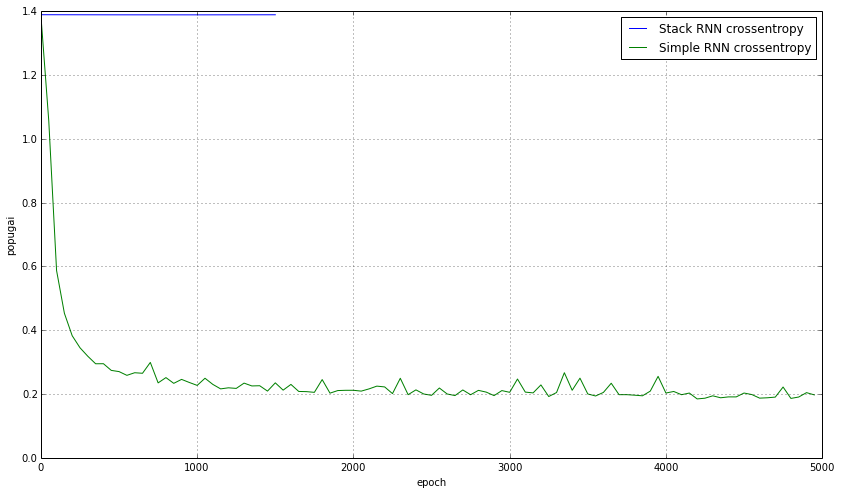

In [52]:
N_EPOCHS = 2000 # they seem to almost converge before 1000 anyway
REPORT_RATE = 100

output_shape = (None,)
observation_layer = InputLayer(output_shape,name="obs_input")
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer,
                                              input_size=n_tokens,
                                              output_size=n_tokens,
                                              name = "input_embedding")
n_hid_1 = 64
prev_rnn_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")
stack_width = 2
stack_depth = 50
prev_stack_layer = InputLayer((None,stack_depth,stack_width))
stack_controls_layer = DenseLayer(prev_rnn_layer, num_units=3, name='stack controls', b=None,
                                  nonlinearity=lasagne.nonlinearities.softmax)
stack_input_layer = DenseLayer(prev_rnn_layer, num_units=stack_width, name='rnn stack to hidden', b=None,
                               nonlinearity=lasagne.nonlinearities.tanh)
next_stack = StackAugmentationLayer(stack_input_layer,
                                    prev_stack_layer,
                                    stack_controls_layer)
stack_top = lasagne.layers.SliceLayer(next_stack,0,1)
rnn_frominput = DenseLayer(obs_embedding,
                           num_units=n_hid_1,
                           name= "rnn input to hidden",
                           b = None,
                           nonlinearity = None)
rnn_fromhidden = DenseLayer(prev_rnn_layer,
                            num_units=n_hid_1,
                            name= "rnn hidden to hidden",
                            nonlinearity = None,)
rnn_fromstack = DenseLayer(stack_top,
                            num_units=n_hid_1,
                            name= "rnn stack to hidden",
                            nonlinearity = None)
rnn_sum = ElemwiseSumLayer([
        rnn_frominput,
        rnn_fromhidden,
        rnn_fromstack
    ],
    name = "rnn_sum")
rnn = NonlinearityLayer(rnn_sum,lasagne.nonlinearities.tanh,
                        name = "rnn nonlinearity")

memory_dict = OrderedDict([
            (rnn,prev_rnn_layer),
            (next_stack, prev_stack_layer)
    ])
probability_layer = lasagne.layers.DenseLayer(rnn,
                                         num_units = n_tokens,
                                         nonlinearity=  lasagne.nonlinearities.softmax,
                                         name="policy_original")
resolver = ProbablisticResolver(probability_layer,
                                assume_normalized=True,
                                name="resolver")
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)
agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )
weights = lasagne.layers.get_all_params(resolver,trainable=True)
probas_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)[-1]
model_loss = lasagne.objectives.categorical_crossentropy(
    T.maximum(probas_seq[:,:-1],1e-10).reshape([-1,n_tokens]),
    sequences_batch[:,1:].ravel()
).mean()
loss = model_loss + regularize_network_params(resolver,l2)*10**-4
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])
gen_batch_size = T.scalar('generated batch size','int32')
generated_action_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             batch_size=gen_batch_size,)[-2]
get_sequences = theano.function([gen_batch_size],generated_action_seq)
metrics = defaultdict(dict)
for i in range(N_EPOCHS):
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    train_fun(new_batch)
    if i % REPORT_RATE==0:
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))
        metrics['crossentropy'][i]=float(loss_components[1])
        examples = get_sequences(1000)
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        print "Correctness rate: %.5f"%(correctness_ratio)
        print "C mean absolut error: %.5f"%(c_count_mae)
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))
for metric in metrics:
    plt.figure(figsize=[14,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label='Stack RNN '+metric)
    plt.plot(*zip(*sorted(rnn_metrics[metric].items(),key=lambda (k,v):k)),label='Simple RNN '+metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()
    plt.show()

**_Changing stack dimensions: depth = 10_**

iter:0	full:1.39487	llh:1.38554	reg:0.00338
Correctness rate: 0.03583
C mean absolut error: 2.61840
b c c c | | b a b | a c a | b | b a | c | | | | c c | c b c b | | b c a c a | a a b | c c c a b c b a c b | b b b c | c c c | | b | b c b b b a b c b a c b b | c c a | c | a a a | b b a b a c a a b c
a c a b a c a | b | c | c c b | b b c a a | b c b b a b c b b a | b c a | c | b c b | a a a b c b b | b b c a c a a a a b a c | a b a a | c a c | | | c a c a | c a b | c | b | a b b b c | b c c | a c
b | b c c | a b a c | c b a a a b | a | b b b | a b | | c | c a b a c c a b | | c a b | c b a b | | | c c a b b a c c | a a b b | c | a c c b | b | c b b c | a b | c | c c | b a | a c c a b c a c a b
iter:50	full:1.39504	llh:1.38571	reg:0.00338
Correctness rate: 0.03655
C mean absolut error: 2.71746
c | a c c | a | | a b a c | | c a | c b b a b | | c c b b b c | | a | | b | | | b a c b c b a c | | a b b | b b a c b | a b b b c | | c a b | | | | b b | a c | b c a b a a a a | c c a b c b a | a a b

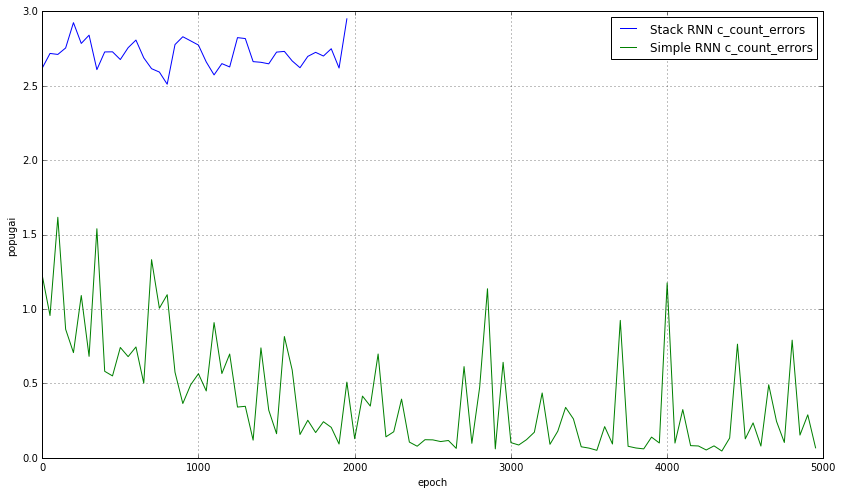

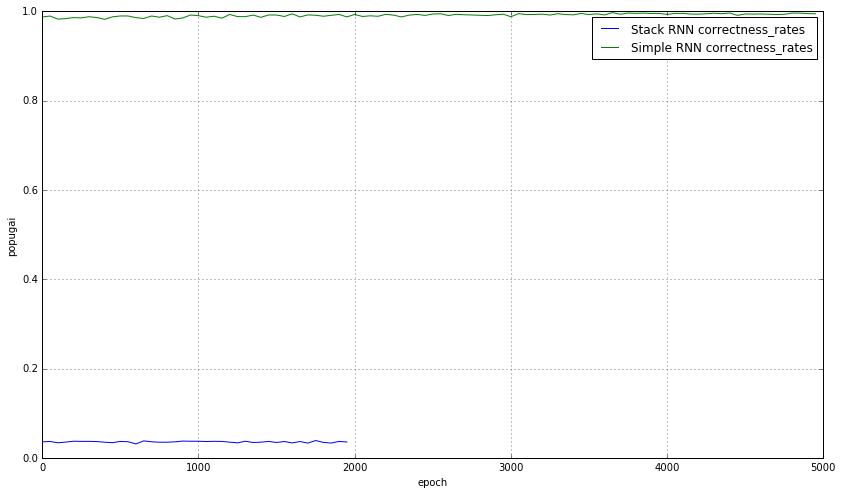

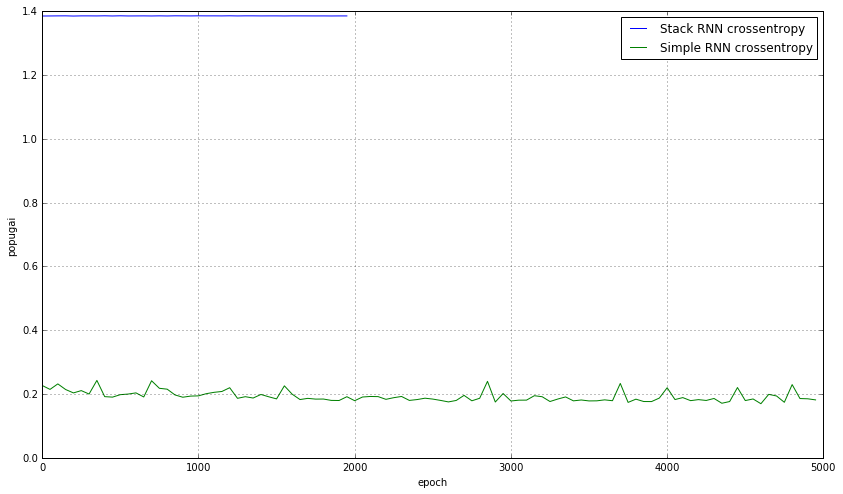

In [50]:

N_EPOCHS = 2000
REPORT_RATE = 100

output_shape = (None,)
observation_layer = InputLayer(output_shape,name="obs_input")
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer,
                                              input_size=n_tokens,
                                              output_size=n_tokens,
                                              name = "input_embedding")
n_hid_1 = 64
prev_rnn_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")
stack_width = 3
stack_depth = 10
prev_stack_layer = InputLayer((None,stack_depth,stack_width))
stack_controls_layer = DenseLayer(prev_rnn_layer, num_units=3, name='stack controls', b=None,
                                  nonlinearity=lasagne.nonlinearities.softmax)
stack_input_layer = DenseLayer(prev_rnn_layer, num_units=stack_width, name='rnn stack to hidden', b=None,
                               nonlinearity=lasagne.nonlinearities.tanh)
next_stack = StackAugmentationLayer(stack_input_layer,
                                    prev_stack_layer,
                                    stack_controls_layer)
stack_top = lasagne.layers.SliceLayer(next_stack,0,1)
rnn_frominput = DenseLayer(obs_embedding,
                           num_units=n_hid_1,
                           name= "rnn input to hidden",
                           b = None,
                           nonlinearity = None)
rnn_fromhidden = DenseLayer(prev_rnn_layer,
                            num_units=n_hid_1,
                            name= "rnn hidden to hidden",
                            nonlinearity = None,)
rnn_fromstack = DenseLayer(stack_top,
                            num_units=n_hid_1,
                            name= "rnn stack to hidden",
                            nonlinearity = None)
rnn_sum = ElemwiseSumLayer([
        rnn_frominput,
        rnn_fromhidden,
        rnn_fromstack
    ],
    name = "rnn_sum")
rnn = NonlinearityLayer(rnn_sum,lasagne.nonlinearities.tanh,
                        name = "rnn nonlinearity")
from collections import OrderedDict
memory_dict = OrderedDict([
            (rnn,prev_rnn_layer),
            (next_stack, prev_stack_layer)
    ])
probability_layer = lasagne.layers.DenseLayer(rnn,
                                         num_units = n_tokens,
                                         nonlinearity=  lasagne.nonlinearities.softmax,
                                         name="policy_original")
resolver = ProbablisticResolver(probability_layer,
                                assume_normalized=True,
                                name="resolver")
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)
agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )
weights = lasagne.layers.get_all_params(resolver,trainable=True)
probas_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)[-1]
model_loss = lasagne.objectives.categorical_crossentropy(
    T.maximum(probas_seq[:,:-1],1e-10).reshape([-1,n_tokens]),
    sequences_batch[:,1:].ravel()
).mean()
loss = model_loss + regularize_network_params(resolver,l2)*10**-4
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])
gen_batch_size = T.scalar('generated batch size','int32')
generated_action_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             batch_size=gen_batch_size,)[-2]
get_sequences = theano.function([gen_batch_size],generated_action_seq)
metrics = defaultdict(dict)
for i in range(N_EPOCHS):
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    train_fun(new_batch)
    if i % REPORT_RATE==0:
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))
        metrics['crossentropy'][i]=float(loss_components[1])
        examples = get_sequences(1000)
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        print "Correctness rate: %.5f"%(correctness_ratio)
        print "C mean absolut error: %.5f"%(c_count_mae)
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))
for metric in metrics:
    plt.figure(figsize=[14,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label='Stack RNN '+metric)
    plt.plot(*zip(*sorted(rnn_metrics[metric].items(),key=lambda (k,v):k)),label='Simple RNN '+metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()
    plt.show()

**_Changing stack dimensions: depth = 20_**

iter:0	full:1.41411	llh:1.40477	reg:0.00338
Correctness rate: 0.03733
C mean absolut error: 2.64586
b c c c | | b a b | a c a | b | b a | c | | | | c c | c b c b | | b c a c a | a a b | c b c a a c b a c b | a b b c | c c c | | b | b c a b b a b c c a c c b | c c a | c | | a b | b c a b a c | a b b
a c a b a c a | b | c | c c b | b b c a a | b c b b a b c c b a | b c a | c | b c a | a a b b b b b | b b c a c a a a b b a c | a b a a | c a c | a a b a c a | c a b | c | b a a b b c c | b c c | b c
b | b c c | a b a c | c b a a a b | a a b b b | a c | | c | c a b a c b a b | a c a c | c b a b | | | b c a b b a c c | a a b b | c | b c c c | a | c b b c | a b | c | c b | b a | a c c | b c a c b a
iter:50	full:1.41442	llh:1.40509	reg:0.00338
Correctness rate: 0.03516
C mean absolut error: 2.60863
c | a c c | a | | a b a c | | c a | c b b | b | | c c b b b c | | a | | b | | | c a c b c b a c | | a c b | b b | b b | a c c b c a | c b b | | | | a b | a c | a b a b a a a a | c c a b c b | | a a b

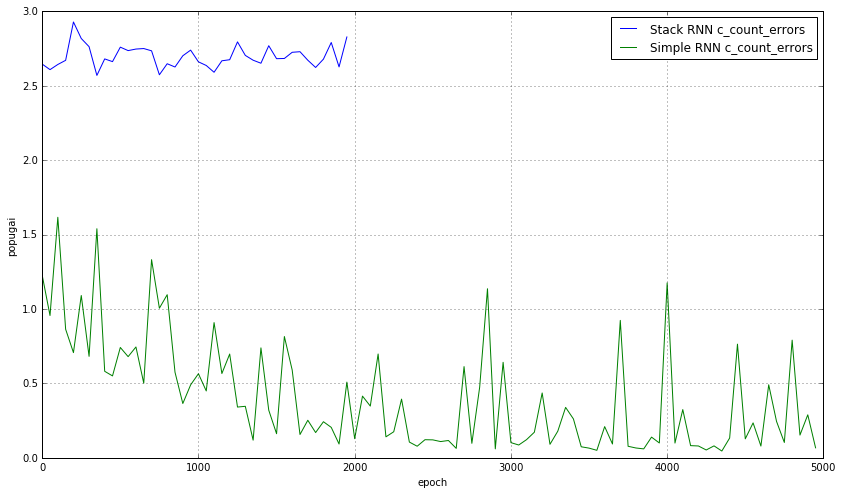

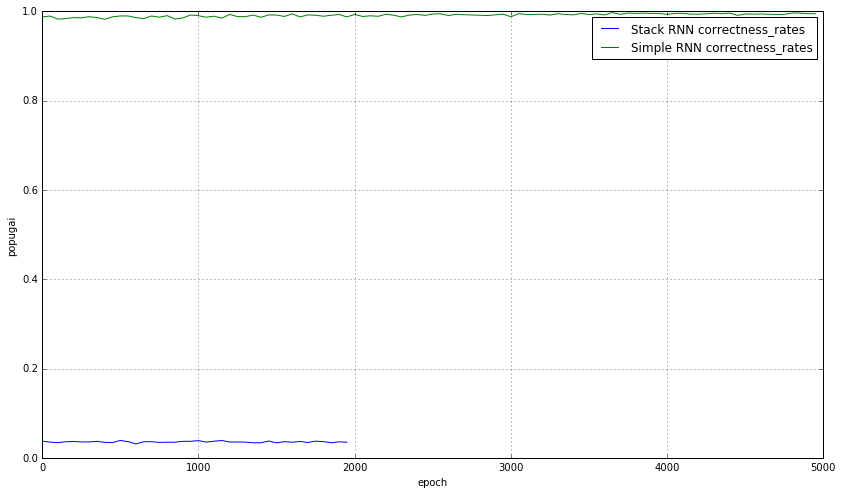

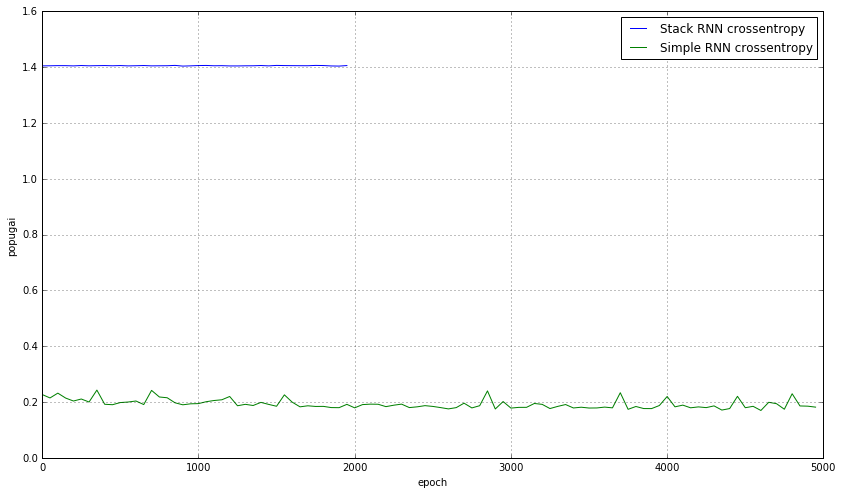

In [51]:

N_EPOCHS = 2000

output_shape = (None,)
observation_layer = InputLayer(output_shape,name="obs_input")
n_tokens = len(alphabet)
obs_embedding = EmbeddingLayer(observation_layer,
                                              input_size=n_tokens,
                                              output_size=n_tokens,
                                              name = "input_embedding")
n_hid_1 = 64
prev_rnn_layer = InputLayer((None,n_hid_1),name="prev_rnn_state")
stack_width = 3
stack_depth = 20
prev_stack_layer = InputLayer((None,stack_depth,stack_width))
stack_controls_layer = DenseLayer(prev_rnn_layer, num_units=3, name='stack controls', b=None,
                                  nonlinearity=lasagne.nonlinearities.softmax)
stack_input_layer = DenseLayer(prev_rnn_layer, num_units=stack_width, name='rnn stack to hidden', b=None,
                               nonlinearity=lasagne.nonlinearities.tanh)
next_stack = StackAugmentationLayer(stack_input_layer,
                                    prev_stack_layer,
                                    stack_controls_layer)
stack_top = lasagne.layers.SliceLayer(next_stack,0,1)
rnn_frominput = DenseLayer(obs_embedding,
                           num_units=n_hid_1,
                           name= "rnn input to hidden",
                           b = None,
                           nonlinearity = None)
rnn_fromhidden = DenseLayer(prev_rnn_layer,
                            num_units=n_hid_1,
                            name= "rnn hidden to hidden",
                            nonlinearity = None,)
rnn_fromstack = DenseLayer(stack_top,
                            num_units=n_hid_1,
                            name= "rnn stack to hidden",
                            nonlinearity = None)
rnn_sum = ElemwiseSumLayer([
        rnn_frominput,
        rnn_fromhidden,
        rnn_fromstack
    ],
    name = "rnn_sum")
rnn = NonlinearityLayer(rnn_sum,lasagne.nonlinearities.tanh,
                        name = "rnn nonlinearity")
from collections import OrderedDict
memory_dict = OrderedDict([
            (rnn,prev_rnn_layer),
            (next_stack, prev_stack_layer)
    ])
probability_layer = lasagne.layers.DenseLayer(rnn,
                                         num_units = n_tokens,
                                         nonlinearity=  lasagne.nonlinearities.softmax,
                                         name="policy_original")
resolver = ProbablisticResolver(probability_layer,
                                assume_normalized=True,
                                name="resolver")
assert tuple(lasagne.layers.get_output_shape(resolver)) == tuple(output_shape)
agent = Generator(
    observation_layer,
    memory_dict,
    probability_layer,
    resolver
    )
weights = lasagne.layers.get_all_params(resolver,trainable=True)
probas_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             recorded_sequences=sequences_batch,
                             batch_size=batch_size,)[-1]
model_loss = lasagne.objectives.categorical_crossentropy(
    T.maximum(probas_seq[:,:-1],1e-10).reshape([-1,n_tokens]),
    sequences_batch[:,1:].ravel()
).mean()
loss = model_loss + regularize_network_params(resolver,l2)*10**-4
train_fun = theano.function([sequences_batch],[loss],updates=updates)
evaluation_fun = theano.function([sequences_batch],[loss,model_loss,reg_l2])
gen_batch_size = T.scalar('generated batch size','int32')
generated_action_seq = agent.get_sessions(session_length=SEQ_LENGTH,
                             batch_size=gen_batch_size,)[-2]
get_sequences = theano.function([gen_batch_size],generated_action_seq)
metrics = defaultdict(dict)
for i in range(N_EPOCHS):
    new_batch = generate_sequence(BATCH_SIZE,SEQ_LENGTH)
    train_fun(new_batch)
    if i % REPORT_RATE==0:
        loss_components = evaluation_fun(new_batch)
        print "iter:%i\tfull:%.5f\tllh:%.5f\treg:%.5f"%tuple([i]+map(float,loss_components))
        metrics['crossentropy'][i]=float(loss_components[1])
        examples = get_sequences(1000)
        correctness_ratio,c_count_mae = get_metrics(examples,alphabet)
        metrics["correctness_rates"][i] = correctness_ratio
        metrics["c_count_errors"][i]=c_count_mae
        print "Correctness rate: %.5f"%(correctness_ratio)
        print "C mean absolut error: %.5f"%(c_count_mae)
        for tid_line in examples[:3]:
            print ' '.join(map(alphabet.__getitem__,tid_line))
for metric in metrics:
    plt.figure(figsize=[16,8])
    plt.plot(*zip(*sorted(metrics[metric].items(),key=lambda (k,v):k)),label='Stack RNN '+metric)
    plt.plot(*zip(*sorted(rnn_metrics[metric].items(),key=lambda (k,v):k)),label='Simple RNN '+metric)
    plt.legend(loc='best')
    plt.ylabel("popugai")
    plt.xlabel("epoch")
    plt.grid()
    plt.show()


# Okay, who won after all?

I say the model #3 (stack-augmented, stack_width = 3, stack_depth = 50, neuron counts divided by 2 is the winner). It seems that I  messed up the other ones, but, whatever.

P.S. Please try to come up with a better problem to test all these horrible contaptions on for the next time.

` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `


` `




##### And, well, you have just crossed the finish line

Someone may have already forgotten, that homework assignments are finite, but you survived and cut through all of them in a heroic charge.

We all know that this course was far from ideal, and at times, from decent, and some of you have already given us feedback, and we would be glad to have yours too. Tell us, what was okay, where we have gone too far and what was in direst need of improvement.






Someplace... Here, for example.


**In fact, this was one of the most involving, end-to-end experiences I've had at MIPT, Skoltech or MIT. While certain improvements could be done (uploading the datasets to wgettable places, for example), the overall educational effect is beyond all expectations. I would like to thank instructors and TAs for the great work, and wish them best in the future. Thanks to the course, I am now closer to becoming a Jedi than ever. Good luck and high accuracy!**

![canvas](http://waytorussia.net/sites/default/files/hedgehog-fog-yozhik-v-tumane.jpg)

And yes, thank you for surviving that course with us :)

Yours,
cygnus, lidl and 'da hedgehog.
